<a href="https://colab.research.google.com/github/SalhaAlzahrani/ConvAttenMixer/blob/main/VisionTransfomers_MRI_Brain_Tumor_Classification_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔵 Image classification with Vision Transformers

# 🧠 MRI Brain Tumor Classification

# Requirmenets

In [ ]:
!pip install -U tensorflow-addons
!pip install vit-keras
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 33.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras.metrics
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import SGD,Adam

from vit_keras import vit, utils
from google.colab import drive
import tensorflow_addons as tfa

# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/drive


# Configure the hyperparameters


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
label_smoothing = 0.1

BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 4
input_shape = (224, 224, 3)
NUM_EPOCHS = 30

# Prepare the data

In [ ]:
# train data
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1024,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# validation data
val_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Testing/',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1024,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



---



In [ ]:
#This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)



---



# ConvNeXtXLarge





In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.ConvNeXtXLarge(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
base_model.trainable = False

1393257616/1393257616 [==============================] - 63s 0us/step


In [ ]:
#Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation=('softmax'))
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=input_shape)
x = inputs
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 492s 3s/step - loss: 0.7232 - accuracy: 0.8209 - precision_2: 0.8896 - recall_2: 0.7395 - f1_score: 0.7954 - val_loss: 0.6558 - val_accuracy: 0.8413 - val_precision_2: 0.8855 - val_recall_2: 0.8024 - val_f1_score: 0.8220
Epoch 2/30
179/179 [==============================] - 36s 198ms/step - loss: 0.5660 - accuracy: 0.9063 - precision_2: 0.9303 - recall_2: 0.8675 - f1_score: 0.8913 - val_loss: 0.6016 - val_accuracy: 0.8658 - val_precision_2: 0.9028 - val_recall_2: 0.8291 - val_f1_score: 0.8473
Epoch 3/30
179/179 [==============================] - 36s 198ms/step - loss: 0.5379 - accuracy: 0.9238 - precision_2: 0.9442 - recall_2: 0.8941 - f1_score: 0.9136 - val_loss: 0.5735 - val_accuracy: 0.8795 - val_precision_2: 0.9083 - val_recall_2: 0.8535 - val_f1_score: 0.8693
Epoch 4/30
179/179 [==============================] - 35s 197ms/step - loss: 0.5243 - accuracy: 0.9279 - precision_2: 0.9449 - recall_2: 0.9006 - f1_score: 0.9177 - val_lo

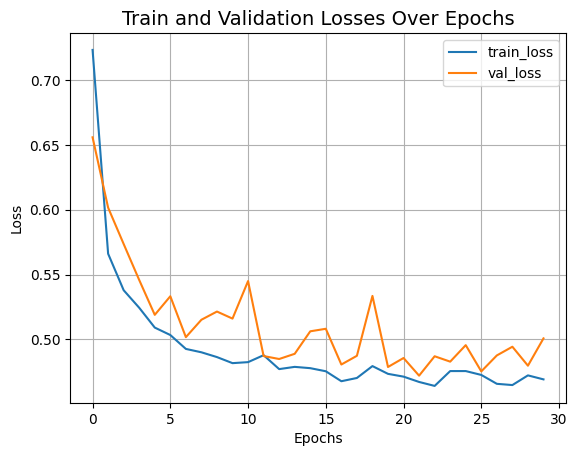

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---



# ConvNeXtLarge





In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.ConvNeXtLarge(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
base_model.trainable = False

785596384/785596384 [==============================] - 38s 0us/step


In [ ]:
#Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation=('softmax'))
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=input_shape)
x = inputs
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 60s 232ms/step - loss: 0.7394 - accuracy: 0.8057 - precision_3: 0.8735 - recall_3: 0.7194 - f1_score: 0.7742 - val_loss: 0.6303 - val_accuracy: 0.8612 - val_precision_3: 0.8982 - val_recall_3: 0.7941 - val_f1_score: 0.8262
Epoch 2/30
179/179 [==============================] - 27s 152ms/step - loss: 0.5708 - accuracy: 0.9046 - precision_3: 0.9277 - recall_3: 0.8666 - f1_score: 0.8897 - val_loss: 0.5901 - val_accuracy: 0.8749 - val_precision_3: 0.9086 - val_recall_3: 0.8268 - val_f1_score: 0.8490
Epoch 3/30
179/179 [==============================] - 27s 151ms/step - loss: 0.5372 - accuracy: 0.9174 - precision_3: 0.9404 - recall_3: 0.8873 - f1_score: 0.9082 - val_loss: 0.5464 - val_accuracy: 0.9008 - val_precision_3: 0.9219 - val_recall_3: 0.8734 - val_f1_score: 0.8883
Epoch 4/30
179/179 [==============================] - 27s 152ms/step - loss: 0.5184 - accuracy: 0.9345 - precision_3: 0.9494 - recall_3: 0.9060 - f1_score: 0.9230 - val_

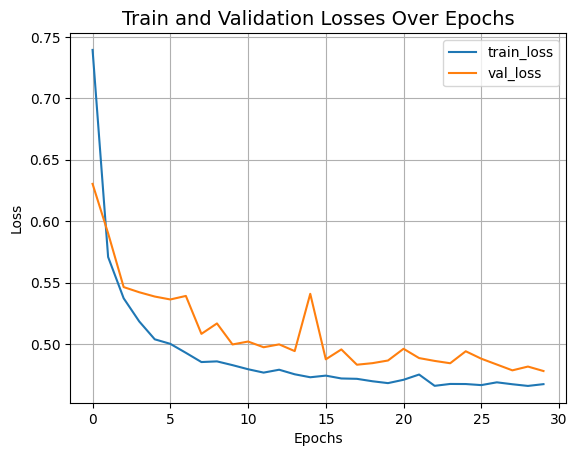

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---



# ConvNeXtBase





In [ ]:
# Create the base model from the pre-trained model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.ConvNeXtBase(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
base_model.trainable = False

350926856/350926856 [==============================] - 18s 0us/step


In [ ]:
#Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation=('softmax'))
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=input_shape)
x = inputs
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 51s 186ms/step - loss: 0.7881 - accuracy: 0.7729 - precision_4: 0.8549 - recall_4: 0.6754 - f1_score: 0.7347 - val_loss: 0.6885 - val_accuracy: 0.8337 - val_precision_4: 0.8870 - val_recall_4: 0.7605 - val_f1_score: 0.7914
Epoch 2/30
179/179 [==============================] - 20s 108ms/step - loss: 0.6193 - accuracy: 0.8727 - precision_4: 0.9160 - recall_4: 0.8206 - f1_score: 0.8557 - val_loss: 0.6416 - val_accuracy: 0.8452 - val_precision_4: 0.8909 - val_recall_4: 0.7910 - val_f1_score: 0.8116
Epoch 3/30
179/179 [==============================] - 20s 109ms/step - loss: 0.5831 - accuracy: 0.8950 - precision_4: 0.9238 - recall_4: 0.8580 - f1_score: 0.8821 - val_loss: 0.6023 - val_accuracy: 0.8734 - val_precision_4: 0.9050 - val_recall_4: 0.8360 - val_f1_score: 0.8577
Epoch 4/30
179/179 [==============================] - 20s 108ms/step - loss: 0.5595 - accuracy: 0.9084 - precision_4: 0.9333 - recall_4: 0.8725 - f1_score: 0.8955 - val_

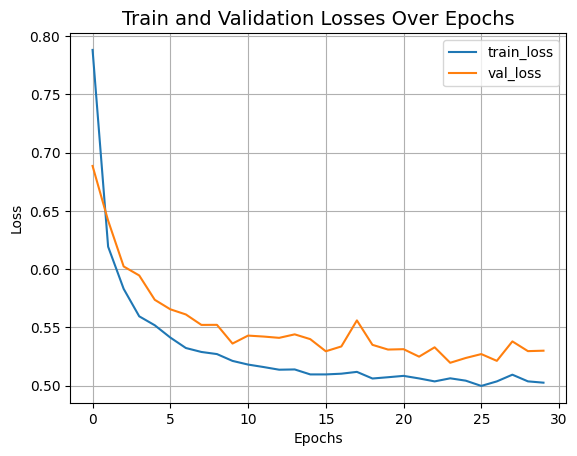

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---

# ⏰ Flush memory varibales before using the next transfomer

In [ ]:
del history
del model
del base_model
del optimizer